In [1]:
import os
import numpy as np
import pandas as pd

from PIL import Image
from matplotlib import pyplot as plt

result_dir = 'C:\\Users\\user\\OneDrive\\桌面\\vertex\\content\\yolov5\\runs\\detect\\exp4\\labels'
DATA_path = 'C:\\Users\\user\\OneDrive\\桌面\\07804334'

data = []

for filename in os.listdir(result_dir):

    img_filename = filename.split('.')[0] + '.bmp'
    img_dir = img_filename.split('_')[0]
    img_path = os.path.join(DATA_path, img_dir, img_filename)

    img = Image.open(img_path)
    img_width, img_height = img.size

    data_temp = dict()
    data_temp['filename'] = img_filename
    data_temp['filepath'] = img_path
    data_temp['predict'] = []

    with open(os.path.join(result_dir, filename), mode='r') as f:
        lines = f.readlines()
        for line in lines:

            temp_dict = dict()

            # by yolov5 output format
            lst = [float(a) for a in line.strip('\n').split(' ')]
            label, x_center_norm, y_center_norm, width_norm, height_norm, predict_conf = lst

            x_center = int(x_center_norm * img_width)
            y_center = int(y_center_norm * img_height)
            box_width = int(width_norm * img_width)
            box_height = int(height_norm * img_height)

            temp_dict['label'] = 'S' if label == 0 else 'others'
            temp_dict['x_center'] = x_center
            temp_dict['y_center'] = y_center
            temp_dict['box_width'] = box_width
            temp_dict['box_height'] = box_height
            temp_dict['conf'] = predict_conf

            data_temp['predict'].append(temp_dict)

    data.append(data_temp)

filename: 07804334_FILE1.bmp
No. of vertexs: 16


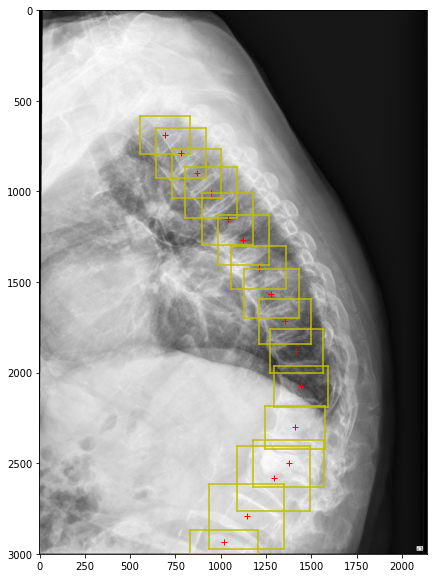

In [2]:
import random

random_id = random.randint(0, len(data)-1)

plt.figure(figsize=(10,10))
d = data[random_id]

img = Image.open(d['filepath'])
preds = d['predict']

print('filename:', d['filename'])
print('No. of vertexs:', len(preds))
plt.imshow(img, cmap='gray')

getLineStyle = {
    'S': '-g',
    'others': '-y',
}

conf_threshold = 0.2

for pred in preds:

    if pred['conf'] < conf_threshold:
        continue

    x_c, y_c = pred['x_center'], pred['y_center']
    w, h = pred['box_width'], pred['box_height']

    x_min, y_min, x_max, y_max = x_c-w/2, y_c-h/2, x_c+w/2, y_c+h/2

    style = getLineStyle[pred['label']]

    plt.plot([x_min, x_min], [y_min, y_max], style)
    plt.plot([x_max, x_max], [y_min, y_max], style)
    plt.plot([x_min, x_max], [y_min, y_min], style)
    plt.plot([x_min, x_max], [y_max, y_max], style)

    if pred['label'] != 'S':
        plt.plot(x_c, y_c, 'r+')

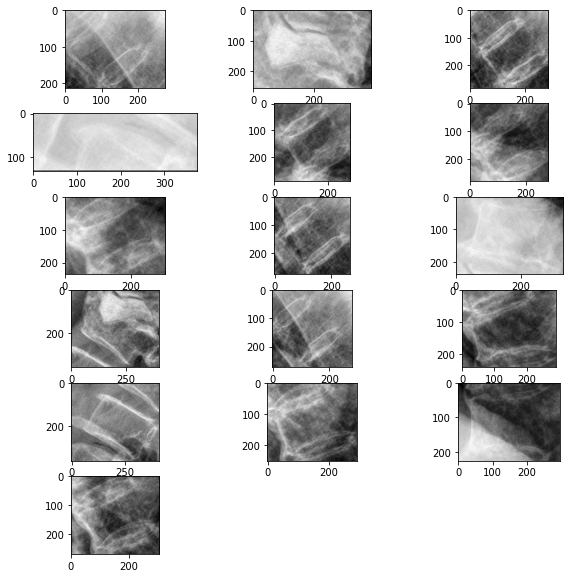

In [3]:
plt.figure(figsize=(10,10))

ncols = 3
nrows = int(len(preds)/ncols)+1

idx = 0

for pred in preds:    
    
    if pred['conf'] < conf_threshold:
        continue
    else:
        idx += 1

    x_c, y_c = pred['x_center'], pred['y_center']
    w, h = pred['box_width'], pred['box_height']

    box = (x_c-w/2, y_c-h/2, x_c+w/2, y_c+h/2)

    plt.subplot(nrows, ncols, idx)
    plt.imshow(img.crop(box), cmap='gray')

In [4]:
from MyLoad import MyLoadDATA

data = MyLoadDATA()

.\content\DATA\00048035\00048035.json
.\content\DATA\01142281\01142281.json
.\content\DATA\016047953\106047953.json
.\content\DATA\01990231\01990231.json
.\content\DATA\03158534\03158534.json
.\content\DATA\03877078\03877078.json
.\content\DATA\04886479\04886479.json
.\content\DATA\05609172\05609172.json
.\content\DATA\06280116\06280116.json
.\content\DATA\10874765\10874765.json
.\content\DATA\10929576\10929576.json
.\content\DATA\11830358\11830358.json
.\content\DATA\13549073\13549073.json
.\content\DATA\15144615\151446151.json
.\content\DATA\Transform\Transform.json


In [5]:
def DATAtoSeg(segDATA_path, screw_path, nscrew_path):
    
    os.mkdir(segDATA_path)
    os.mkdir(screw_path)
    os.mkdir(nscrew_path)

    excess = 20

    label_dict = dict()

    # save each box of image to /content/segDATA into two files /screw/ or /nscrew/
    # image filename format: [id]_[FILEn]_[position].bmp

    for d in data:
        
        img = Image.open(d['filepath'])
        img_width, img_height = img.size
        img_filename = d['filename'].split('.')[0]

        for idx in range(len(d['x_label'])):

            if d['position'][idx] == 'S':
                continue

            x_min = max(0, min(d['x_label'][idx]) - excess)
            x_max = min(img_width, max(d['x_label'][idx]) + excess)
            y_min = max(0, min(d['y_label'][idx]) - excess)
            y_max = min(img_height, max(d['y_label'][idx]) + excess)

            box = (x_min, y_min, x_max, y_max)

            seg_img = img.crop(box)
            seg_img_filename = img_filename + '_{}.bmp'.format(d['position'][idx])

            seg_img_dirpath = screw_path if d['type'][idx] == 'unsure' else nscrew_path

            seg_img_filepath = os.path.join(seg_img_dirpath, seg_img_filename)
            seg_img.save(seg_img_filepath)
            

In [6]:
import torchvision.transforms.functional as TF

def FillsegDATA(segDATA_path, screw_path, nscrew_path):

    n_screw = len(os.listdir(screw_path))
    n_nscrew = len(os.listdir(nscrew_path))

    screw_path_list = [os.path.join(screw_path, filename) for filename in os.listdir(screw_path)]

    ndata_to_add = n_nscrew - n_screw

    for i in range(ndata_to_add):

        rnd = random.randint(0, n_screw-1)
        img = Image.open(screw_path_list[rnd])    
        random_angle = random.randint(-80, 80)

        rotate_img = TF.rotate(img, random_angle, expand=True)
        
        fp = os.path.join(screw_path, 'Transform' + str(i) + '.bmp')
        rotate_img.save(fp)

def DeletesegDATA(segDATA_path, screw_path, nscrew_path):

    n_screw = len(os.listdir(screw_path))
    n_nscrew = len(os.listdir(nscrew_path))

    nscrew_path_list = [os.path.join(nscrew_path, filename) for filename in os.listdir(nscrew_path)]

    # tolerate 20 n_nscrew more than n_screw
    ndata_to_delete = n_nscrew - n_screw - 20

    random_sample_ids = random.sample(range(n_nscrew), k=ndata_to_delete)
    
    for idx in random_sample_ids:
        os.remove(nscrew_path_list[idx])

In [7]:
segDATA_path = './content/segDATA'
screw_path = os.path.join(segDATA_path, 'screw')
nscrew_path = os.path.join(segDATA_path, 'nscrew')

DATAtoSeg(segDATA_path, screw_path, nscrew_path)
# FillsegDATA(segDATA_path, screw_path, nscrew_path)
DeletesegDATA(segDATA_path, screw_path, nscrew_path)